# 네이버 웹툰
이미지 다운로드 + header

In [1]:
# 네이버 웹툰은
# 한 편이 여러개의 이미지로 잘개 쪼개져 있다
# 심지어 이미지 다운로드는 header 에 추가정보가 있어야 제대로 response 된다.

In [2]:
import requests
from bs4 import BeautifulSoup

import os
import re
import urllib.parse as urlparser
from os.path import basename, splitext, split
from IPython.display import Image

In [3]:
url = "https://comic.naver.com/webtoon/detail.nhn?titleId=626907&no=347&weekday=wed"

In [4]:
response = requests.get(url)
response

<Response [200]>

In [5]:
dom = BeautifulSoup(response.text, 'html.parser')

In [6]:
# 에피소드 타이틀
title = dom.select_one("div.tit_area > .view > h3").text.strip()
title

'345화 인류의 미래 4화'

In [7]:
# 등록일
date = dom.select_one('div.vote_lst .rt dd.date').text.strip()
date

'2021.05.25'

In [8]:
# 이미지(들)
img_elements = dom.select("#comic_view_area .wt_viewer img")
len(img_elements)

64

In [9]:
[
    element.attrs['src']
    for element in img_elements
]

['https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_1.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_2.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_3.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_4.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_5.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_6.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_7.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_8.jpg',
 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14

## 이미지 하나 다운로드

In [10]:
img_url = 'https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_1.jpg'

In [11]:
response = requests.get(img_url, stream=True)
response

<Response [403]>

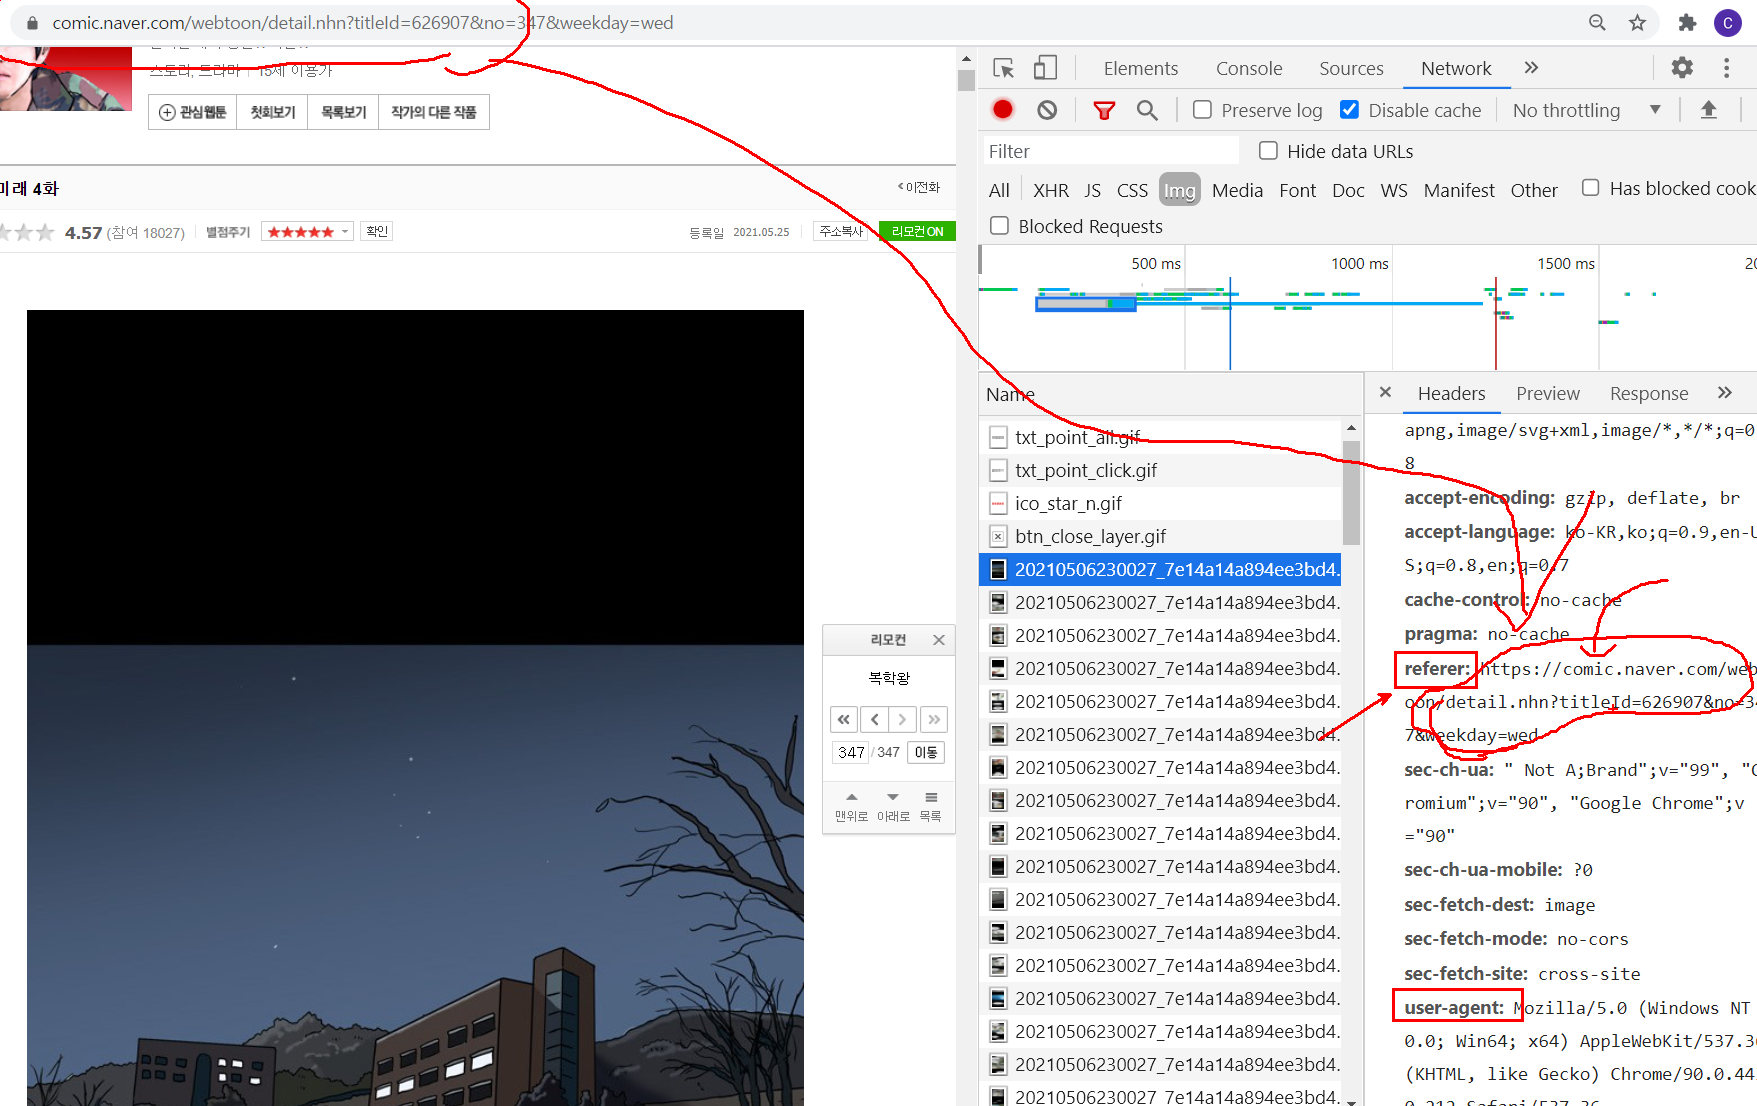

In [12]:
headers = {
    "Referer" : url,
    "User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36'
}

In [13]:
response = requests.get(img_url, headers=headers, stream=True)
response

<Response [200]>

In [14]:
basepath = r'D:\DevRoot\DataSet\download'

In [15]:
with open(os.path.join(basepath, 'naverwebtoon.jpg'), 'wb') as f:
    f.write(response.content)

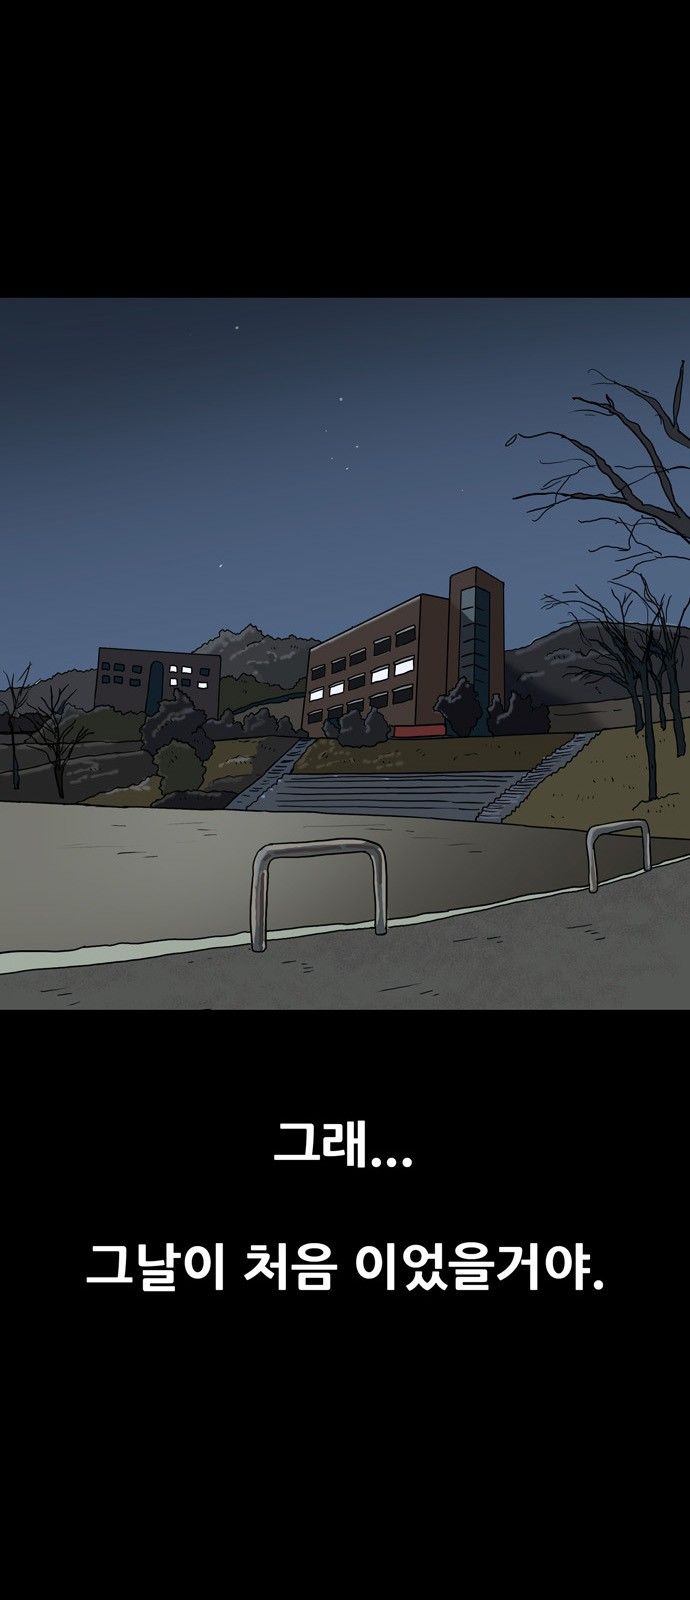

In [16]:
Image(os.path.join(basepath, 'naverwebtoon.jpg'))

# 특정 작품(titleId) 의 특정회(no) 크롤링 하기

In [20]:
# 숫자에 패딩 문자 집어 넣기

# 4  --> 0004
# 234 -> 0234
# 12 --> 0012

padd = 4
'%05d' % (10)
'%05d' % (111)
'%05d' % (1234)
f'%0{padd}d' % (3)

'0003'

#### 디렉토리, 파일명으로 사용할수 없는 문자
 \ / : * ? " < > | 

In [25]:
S = "?\"aa<>|bb/:\\cc*?"
out = re.sub('[\\\\/:*?"<>\|]', '', S)  # 해당문자제거
print(out)
out = re.sub('[\\\\/:*?"<>\|]', '-', S)  # 해당문자 다른 문자로 치환
print(out)

aabbcc
--aa---bb---cc--


In [30]:
headers = {
    "Referer" : url,
    "User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36'
}

basepath = r'D:\DevRoot\DataSet\download'

def download_naver_webtoon(titleId, no, padding=0):
    pad_no = f'%0{padding}d' % (no) if padding > 0 else no
    
    # 1. 페이지 로딩 -> img url 저장.
    url = f"https://comic.naver.com/webtoon/detail.nhn?titleId={titleId}&no={no}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print('페이지 로딩 실패')
        return
    
    dom = BeautifulSoup(response.text, 'html.parser')
    
    #에피소드 타이틀
    title = dom.select_one("div.tit_area > .view > h3").text.strip() 
    
    # 등록일
    date = dom.select_one("div.vote_lst .rt dd.date").text.strip()
    
    # 이미지 url(들)
    img_elements = dom.select("#comic_view_area .wt_viewer img")
    
    print(no, title, len(img_elements), '개 이미지') # 테스트
    
    img_urls = [
        element.attrs['src']
        for element in img_elements
    ]
    
    # 2. 이미지 다운로드
    dirName = re.sub('[\\\\/:*?"<>\|.]', '-', f'{title}({date})')  # . 도 경로명 문자열에선 사용하기 곤란.
    saveDir = os.path.join(basepath, f'{pad_no}_{dirName}')  # 저장할 디렉토리
    if not os.path.exists(saveDir):
        os.mkdir(saveDir)
    
    for img_url in img_urls:
        # 파일명 추출
        disaseembled = urlparser.urlparse(img_url)
        filename = basename(disaseembled.path)
        
        savePath = os.path.join(saveDir, filename)  # 저장 파일명 (전체 경로)
        
        print('다운로드:', img_url, '->', savePath)
        
        response = requests.get(img_url, headers=headers, stream=True)
        
        if response.status_code != 200:
            print('실패')
            continue
            
        with open(savePath, 'wb') as f:
            f.write(response.content)
            print('성공')
    

titleId = 626907  # 작품id
no = 347  # 에피소드id
download_naver_webtoon(titleId, no, 4)

347 345화 인류의 미래 4화 64 개 이미지
다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_1.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_1.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_2.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_2.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_3.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_3.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_4.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_4

다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_36.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_36.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_37.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_37.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_38.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_38.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/626907/347/20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_39.jpg -> D:\DevRoot\DataSet\download\0347_345화 인류의 미래 4화(2021-05-25)\20210506230027_7e14a14a894ee3bd4bd3feda398774cb_IMAG01_39.jpg
성공
다운로드: https:

In [31]:
titleId = 20853  # 작품id
no = 1  # 에피소드id
download_naver_webtoon(titleId, no, 4)

1 마음의 소리 1화 <진실> 3 개 이미지
다운로드: https://image-comic.pstatic.net/static/agerate/age_all_white.jpg -> D:\DevRoot\DataSet\download\0001_마음의 소리 1화 -진실-(2006-09-08)\age_all_white.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/20853/1/20200221113316_5d67ceb80d61b164dc488858740faa50_IMAG01_1.jpg -> D:\DevRoot\DataSet\download\0001_마음의 소리 1화 -진실-(2006-09-08)\20200221113316_5d67ceb80d61b164dc488858740faa50_IMAG01_1.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/20853/1/20200221113316_e107f0df7538c811f7b384fffc0d5b41_IMAG01_2.jpg -> D:\DevRoot\DataSet\download\0001_마음의 소리 1화 -진실-(2006-09-08)\20200221113316_e107f0df7538c811f7b384fffc0d5b41_IMAG01_2.jpg
성공


In [33]:
titleId = 20853  # 작품id
startNo = 1
endNo = 20
for no in range(startNo, endNo + 1):
    download_naver_webtoon(titleId, no, 4)

1 마음의 소리 1화 <진실> 3 개 이미지
다운로드: https://image-comic.pstatic.net/static/agerate/age_all_white.jpg -> D:\DevRoot\DataSet\download\0001_마음의 소리 1화 -진실-(2006-09-08)\age_all_white.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/20853/1/20200221113316_5d67ceb80d61b164dc488858740faa50_IMAG01_1.jpg -> D:\DevRoot\DataSet\download\0001_마음의 소리 1화 -진실-(2006-09-08)\20200221113316_5d67ceb80d61b164dc488858740faa50_IMAG01_1.jpg
성공
다운로드: https://image-comic.pstatic.net/webtoon/20853/1/20200221113316_e107f0df7538c811f7b384fffc0d5b41_IMAG01_2.jpg -> D:\DevRoot\DataSet\download\0001_마음의 소리 1화 -진실-(2006-09-08)\20200221113316_e107f0df7538c811f7b384fffc0d5b41_IMAG01_2.jpg
성공
2 마음의 소리 2화 <위협> 1 개 이미지
다운로드: https://image-comic.pstatic.net/webtoon/20853/2/20200221113316_4bbb8ef2808a5294451dc6cc067cea79_IMAG01_1.jpg -> D:\DevRoot\DataSet\download\0002_마음의 소리 2화 -위협-(2006-09-08)\20200221113316_4bbb8ef2808a5294451dc6cc067cea79_IMAG01_1.jpg
성공
3 마음의 소리 3화 <굴욕> 1 개 이미지
다운로드: https://image-comic.pstatic.net/webtoo

성공
